In [34]:
import torch
from pathlib import Path

In [35]:
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
model_dir = root_dir / 'models'

root_dir
data_dir

PosixPath('/home/dkenez/Projects/PFAS---final-project/data')

In [36]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_dir / 'best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/dkenez/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-30 Python-3.11.2 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


requirements: /home/dkenez/.cache/torch/hub/requirements.txt not found, check failed.


In [37]:
model.eval();

In [38]:

# Images
img = data_dir / "raw/final_project/seq_03/image_02/data/0000000000.png"  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

# Results
r = results.pandas().xyxy  # or .show(), .save(), .crop(), .pandas(), etc.

In [42]:
r[0].head()

,xmin,ymin,xmax,ymax,confidence,class,name
0,1129.814087,248.685089,1254.421509,308.483612,0.981212,0,Car
1,1207.143555,250.967987,1332.056885,304.820801,0.976734,0,Car
2,338.926819,215.616150,465.193054,405.654205,0.963926,2,Cyclist
3,1265.219727,250.743759,1388.734497,308.258118,0.961620,0,Car
4,696.684937,227.499542,742.727234,268.622925,0.958391,0,Car


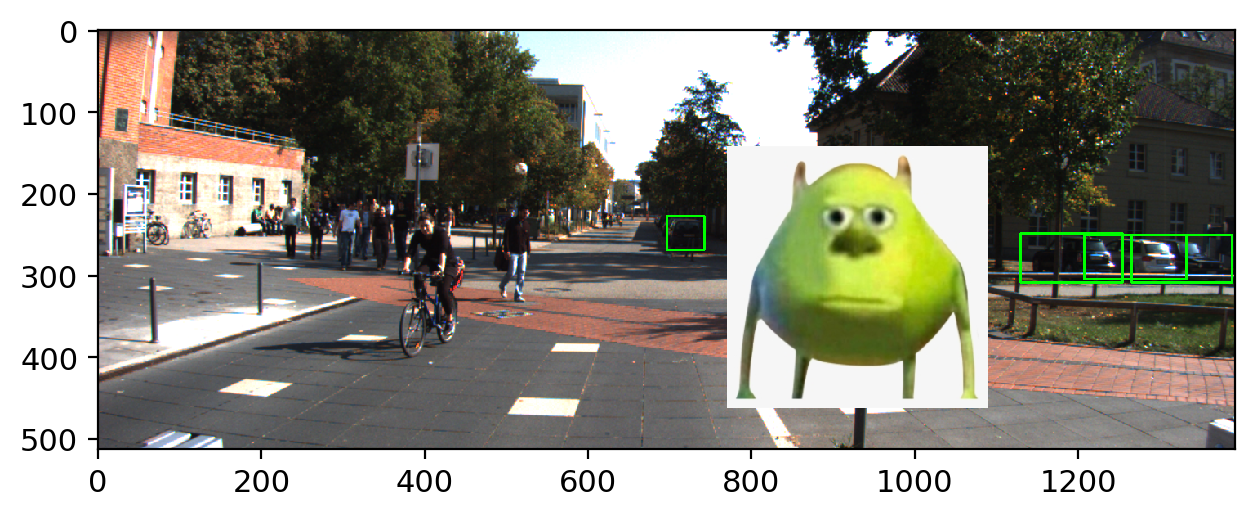

In [40]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format='retina'
from skimage import io
frame = io.imread(img)
for _, box in r[0].iterrows():
    if box["class"]==0:
        xB = int(box["xmin"])
        yB = int(box["ymin"])
        xA = int(box["xmax"])
        yA = int(box["ymax"])
        cv2.rectangle(frame, (xA, yA), (xB, yB), (0, 255, 0), 2)
io.imshow(frame)
io.show()

In [41]:
_, r.xyxy[0].isin([]).head()


AttributeError: 'list' object has no attribute 'xyxy'